In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Input

from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall



# Import file

In [76]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [93]:
y_train = train["label"]
X_train = train.drop("label",axis= 1) / 255

X_test = test /255

In [119]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualize numbers

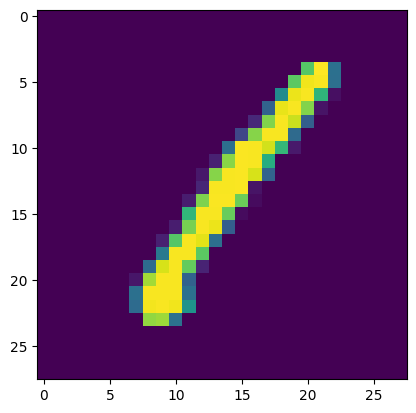

In [94]:
plt.imshow(X_train.loc[0].values.reshape(28,28))

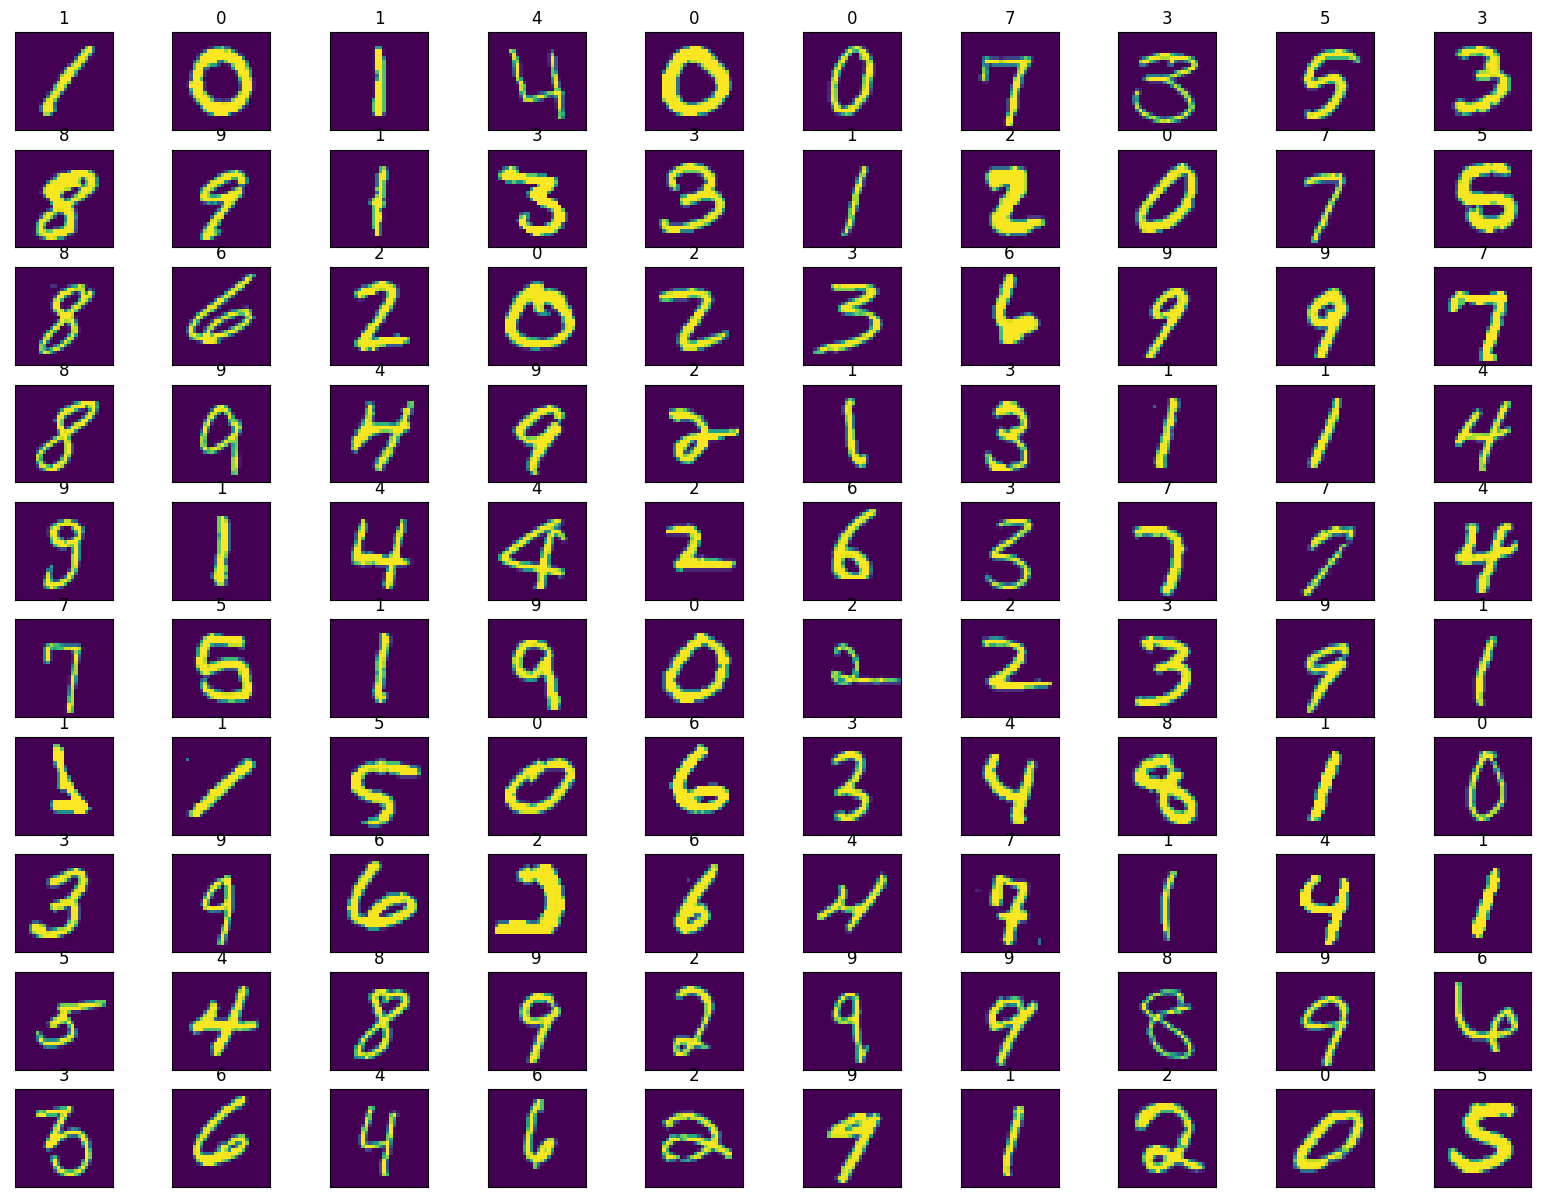

In [68]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(X_train.loc[i].values.reshape(28,28))
    ax.set(xticks=[], yticks=[], title= y_train[i])

# Model

In [143]:
def learning_curve_dl(history, metric):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Baseline

Epoch 1/20
55/55 [==============================] - 1s 16ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.2616 - val_sparse_categorical_accuracy: 0.9243
Epoch 2/20
55/55 [==============================] - 0s 8ms/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9372 - val_loss: 0.1954 - val_sparse_categorical_accuracy: 0.9435
Epoch 3/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1522 - val_sparse_categorical_accuracy: 0.9564
Epoch 4/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.1433 - val_sparse_categorical_accuracy: 0.9582
Epoch 5/20
55/55 [==============================] - 0s 8ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.1212 - val_sparse_categorical_accuracy: 0.9634
Epoch 6/20
55/55 [==============================] - 0s 8ms/step - loss: 0.0727 - sparse_categorical_accuracy:

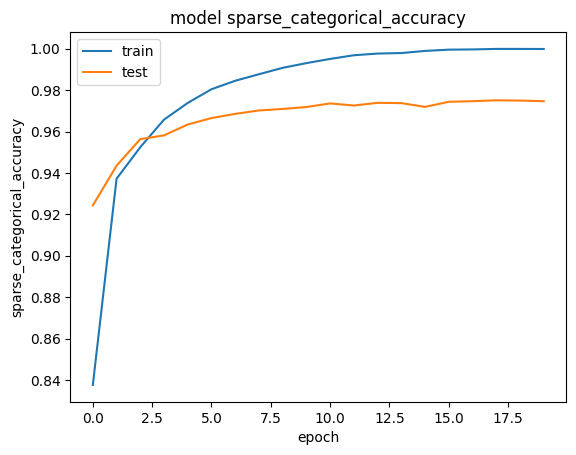

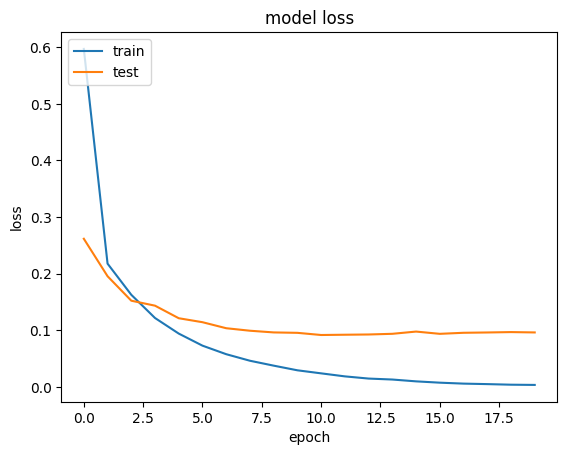

In [144]:
model = Sequential()
model.add(Input(784))
# model.add(Flatten(input_shape = (28,28)))
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))
model.add(Dense(397, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["sparse_categorical_accuracy"])

# Fit the model
history = model.fit(x = X_train, y = y_train,epochs=20, batch_size= 512, validation_split= 0.33 )

learning_curve_dl(history,"sparse_categorical_accuracy")

## Convolutional

In [ ]:
t = X_train.to_numpy().reshape(-1,28,28,1)

data_augmentation = Sequential([
  RandomRotation(0.1),
  RandomTranslation(height_factor=0.1, width_factor=0.1),
  RandomZoom(height_factor=0.1, width_factor=0.1),
])

# Apply the data augmentation pipeline to the training data
x_train = data_augmentation(t)

model = Sequential()
# model.add(Input(784))
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1))) 
model.add(Flatten())
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

# Fit the model
history = model.fit(x = x_train, y = y_train, epochs=20, validation_split= 0.33,batch_size = 128 )

learning_curve_dl(history,"accuracy")

In [ ]:
model